In [2]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, arch_scan, get_data, get_vars, get_constit_vars
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_auc_score, roc_curve
import os
import glob
from tqdm.notebook import tqdm

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quark jets, R = 0.8

In [3]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

vars = ['z','eta','phi']
hdata = get_constit_vars('q',vars,hlevel=True,efrac=False,base=base,nmax=nmax)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_constit_vars('q',vars,hlevel=False,efrac=False,base=base,nmax=nmax)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

del hdata, pdata, htrain, hval, ptrain, pval

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

del perm

In [4]:
import vector

hmult = np.count_nonzero(htest[:,:,0],axis=1)
pmult = np.count_nonzero(ptest[:,:,0],axis=1)

vars = ['pt','eta','phi','e']
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000
hdata = get_vars('q',vars,hlevel=True,efrac=False,base=base,nmax=nmax)
h1, h2 = train_test_split(hdata,train_size=0.5,random_state=rng1)
h2, h3 = train_test_split(h2,train_size=0.5,random_state=rng2)

pdata = get_vars('q',vars,hlevel=False,efrac=False,base=base,nmax=nmax)
p1, p2 = train_test_split(pdata,train_size=0.5,random_state=rng1)
p2, p3 = train_test_split(p2,train_size=0.5,random_state=rng2)

del hdata, pdata, h1, h3, p1, p3

hvec = vector.array({"pt":h2[:,0],"eta":h2[:,1],"phi":h2[:,2],"E":h2[:,3]})
pvec = vector.array({"pt":p2[:,0],"eta":p2[:,1],"phi":p2[:,2],"E":p2[:,3]})

In [5]:
# Evaluate mean/std of AUCs for spectral and non-spectral EFNs
efns = glob.glob("keras_models_v2/qjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_v2/qjet_spectralEFN_zpT_iter*.keras")

efn_aucs = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=1000)
    auc = roc_auc_score(test_labels, preds)
    efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds = efn.predict([test[:,:,0],test[:,:,1:]],batch_size=1000)
    auc = roc_auc_score(test_labels, preds)
    spectral_efn_aucs.append(auc)
    del efn
    del preds
    gc.collect()

spectral_efn_aucs = [a if a>=0.5 else 1-a for a in spectral_efn_aucs]

2023-08-25 17:24:36.538400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 17:24:37.145711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 17:24:37.146416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 17:24:37.163217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

 21/100 [=====>........................] - ETA: 0s

2023-08-25 17:24:40.684540: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 1s 6ms/step


In [6]:
print(f"EFN : AUC = {np.mean(efn_aucs):.4f} +/- {np.std(efn_aucs):.4f}")
print(f"Spectral EFN : AUC = {np.mean(spectral_efn_aucs):.4f} +/- {np.std(spectral_efn_aucs):.4f}")

EFN : AUC = 0.9592 +/- 0.0039
Spectral EFN : AUC = 0.5323 +/- 0.0007


In [20]:
# Computing EFN scores for comparison with EMD
efns = glob.glob("keras_models_v2/qjet_EFN_zpT_iter*.keras")
spectral_efns = glob.glob("keras_models_v2/qjet_spectralEFN_zpT_iter*.keras")
#spectral_efns = ['keras_models_v2/qjet_spectralEFN_zpT_iter1.keras']
#efns = ['keras_models_v2/qjet_EFN_zpT_iter1.keras']

hlevel_efn_scores = []
plevel_efn_scores = []
for efname in efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=1000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=1000)
    hlevel_efn_scores.append(preds_hlevel)
    plevel_efn_scores.append(preds_plevel)
    del efn
    gc.collect()

hlevel_spectral_efn_scores = []
plevel_spectral_efn_scores = []
for efname in spectral_efns:
    efn = keras.models.load_model(efname)
    preds_hlevel = efn.predict([htest[:,:,0],htest[:,:,1:]],batch_size=1000)
    preds_plevel = efn.predict([ptest[:,:,0],ptest[:,:,1:]],batch_size=1000)
    hlevel_spectral_efn_scores.append(preds_hlevel)
    plevel_spectral_efn_scores.append(preds_plevel)
    del efn
    gc.collect()
    
hlevel_efn_scores = np.concatenate(hlevel_efn_scores,axis=1)
plevel_efn_scores = np.concatenate(plevel_efn_scores,axis=1)
hlevel_spectral_efn_scores = np.concatenate(hlevel_spectral_efn_scores,axis=1)
plevel_spectral_efn_scores = np.concatenate(plevel_spectral_efn_scores,axis=1)

50/50 [==============================] - 0s 6ms/step


In [21]:
from scipy.special import logit, expit
#hlevel_efn_scores = logit(hlevel_efn_scores)
#plevel_efn_scores = logit(plevel_efn_scores)
hlevel_spectral_efn_scores = logit(hlevel_spectral_efn_scores)
plevel_spectral_efn_scores = logit(plevel_spectral_efn_scores)

In [34]:
# computing emds
from energyflow.emd import emd_wasserstein, emds_wasserstein
htest_trim = [h[h[:,0]>0] for h in htest]
ptest_trim = [p[p[:,0]>0] for p in ptest]

emds = []
for h,p in tqdm(zip(htest_trim,ptest_trim)):
    emds.append(emd_wasserstein(h,p,R=0.8,norm=False))
    
# computing difference in efn scores
delta_efn = np.abs(hlevel_efn_scores-plevel_efn_scores)
delta_spectral_efn = np.abs(hlevel_spectral_efn_scores-plevel_spectral_efn_scores)

# computing angularity lambda^1 (1-Lipschitz)
z_h = htest[:,:,0]
theta_h = np.linalg.norm(htest[:,:,1:],axis=-1)
angularity_h = np.sum(theta_h*z_h,axis=1)

z_p = ptest[:,:,0]
theta_p = np.linalg.norm(ptest[:,:,1:],axis=-1)
angularity_p = np.sum(theta_p*z_p,axis=1)

delta_lambda1 = np.abs(angularity_p-angularity_h)

kap = 2
bet = 0
ptD_p = np.sum((theta_p**bet)*(z_p**kap),axis=1)
ptD_h = np.sum((theta_h**bet)*(z_h**kap),axis=1)

0it [00:00, ?it/s]

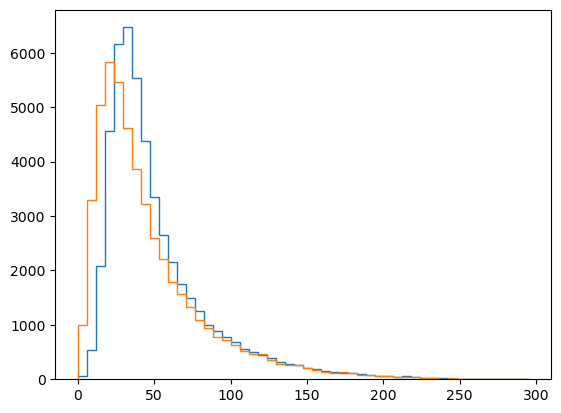

In [10]:
plt.figure()
h1,bins,_ = plt.hist(hvec.mass,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.mass,bins=bins,histtype='step')

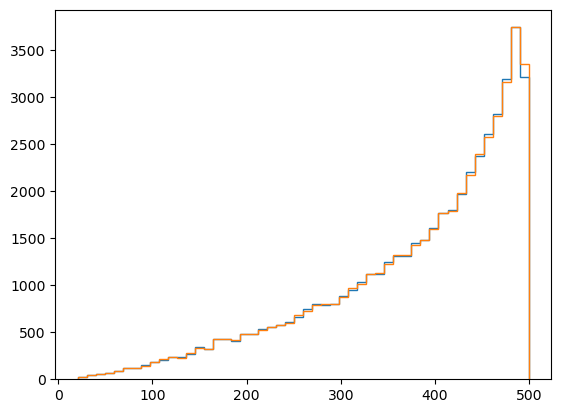

In [11]:
plt.figure()
h1,bins,_ = plt.hist(hvec.pt,bins=50,histtype='step')
h1,bins,_ = plt.hist(pvec.pt,bins=bins,histtype='step')

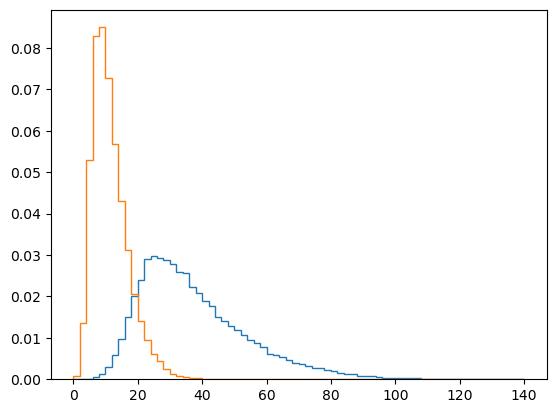

In [12]:
plt.figure()
bins = np.arange(0,142,2)
h1,bins,_ = plt.hist(hmult,bins=bins,histtype='step',density=True)
h1,bins,_ = plt.hist(pmult,bins=bins,histtype='step',density=True)

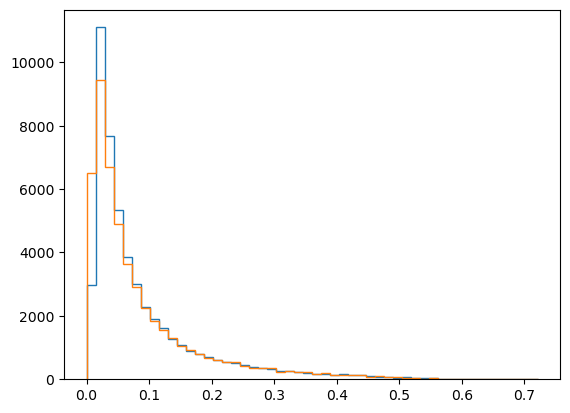

In [13]:
plt.figure()
h1,bins,_ = plt.hist(angularity_h,bins=50,histtype='step')
h1,bins,_ = plt.hist(angularity_p,bins=bins,histtype='step')

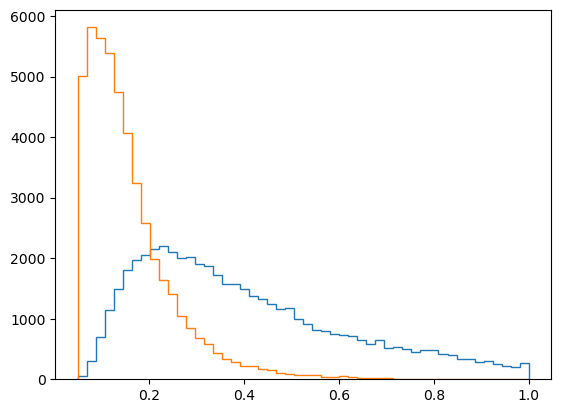

In [14]:
kap = 2
bet = 0
ptD_p = np.sum((theta_p**bet)*(z_p**kap),axis=1)
ptD_h = np.sum((theta_h**bet)*(z_h**kap),axis=1)
plt.figure()
h1,bins,_ = plt.hist(ptD_p,bins=50,histtype='step')
h1,bins,_ = plt.hist(ptD_h,bins=bins,histtype='step')

In [35]:
# Write output file
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2qq_testSet_outputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("jet1_pt_parton",data=pvec.pt)
    f.create_dataset("jet1_eta_parton",data=pvec.eta)
    f.create_dataset("jet1_phi_parton",data=pvec.phi)
    f.create_dataset("jet1_mass_parton",data=pvec.mass)
    f.create_dataset("jet1_EFN_scores_parton",data=plevel_efn_scores)
    f.create_dataset("jet1_spectralEFN_scores_parton",data=plevel_spectral_efn_scores)
    f.create_dataset("jet1_multiplicity_parton",data=pmult)
    f.create_dataset("jet1_ptD_parton",data=ptD_p)
    
    f.create_dataset("jet1_pt_hadron",data=hvec.pt)
    f.create_dataset("jet1_eta_hadron",data=hvec.eta)
    f.create_dataset("jet1_phi_hadron",data=hvec.phi)
    f.create_dataset("jet1_mass_hadron",data=hvec.mass)
    f.create_dataset("jet1_EFN_scores_hadron",data=hlevel_efn_scores)
    f.create_dataset("jet1_spectralEFN_scores_hadron",data=hlevel_spectral_efn_scores)
    f.create_dataset("jet1_multiplicity_hadron",data=hmult)
    f.create_dataset("jet1_ptD_hadron",data=ptD_h)

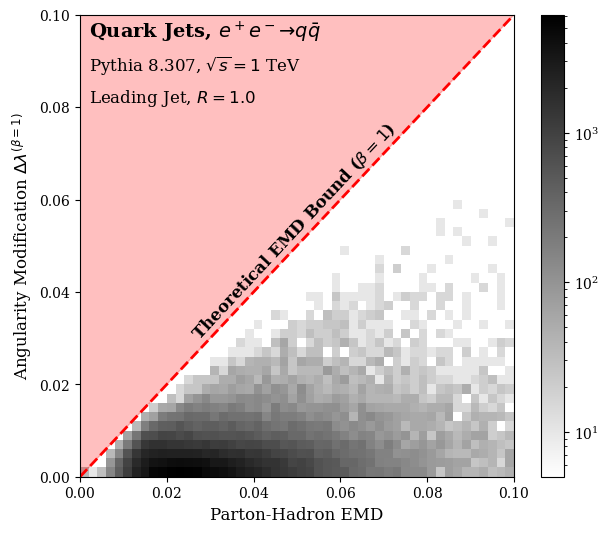

In [38]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,delta_lambda1,bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"Angularity Modification $\Delta\lambda^{(\beta=1)}$",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/qjet_EMD_vs_lambda1_R1.0_pTinclusive.pdf")

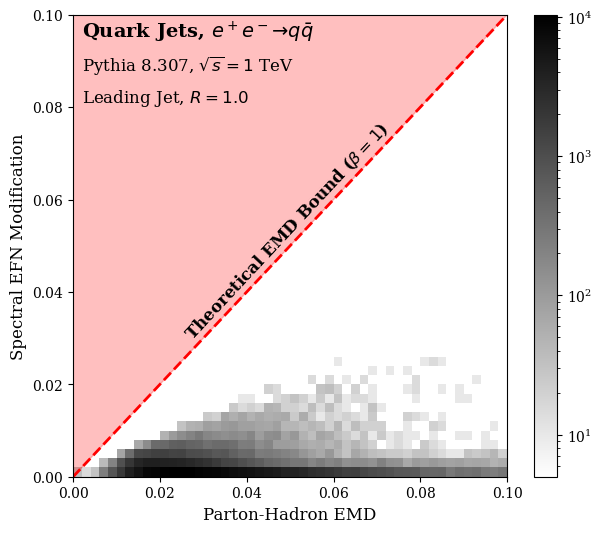

In [39]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.1
binstep = 0.002
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,0.1
binstep = 0.002
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_spectral_efn,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"Spectral EFN Modification",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = 0.6*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.002,0.095,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.002,0.088,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.002,0.081,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.025,0.03,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=47)
plt.savefig("plots/qjet_EMD_vs_spectralEFN_R1.0_pTinclusive.pdf")

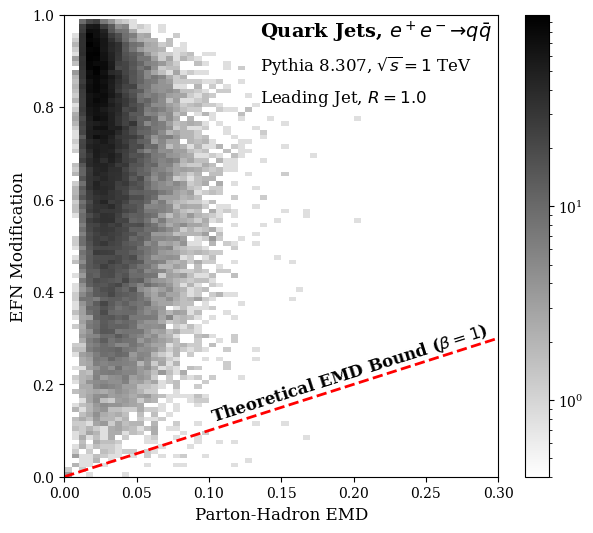

In [42]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})
plt.figure(figsize=(7,6))
from matplotlib.colors import LogNorm

xmin,xmax = 0,0.3
binstep = 0.005
binsx = np.arange(xmin,xmax+0.2,binstep)

ymin,ymax = 0,1
binstep = 0.01
binsy = np.arange(ymin,ymax+0.2,binstep)

h2,bx,by,_ = plt.hist2d(emds,np.mean(delta_efn,axis=1),bins=(binsx,binsy),norm=LogNorm(),density=True,cmap='binary')
plt.colorbar()
plt.xlabel("Parton-Hadron EMD",fontsize=12)
plt.ylabel(r"EFN Modification",fontsize=12)
xl = plt.xlim([xmin,xmax])
yl = plt.ylim([ymin,ymax])
x = np.linspace(xmin,xmax,1000)
y1 = x
y2 = ymax*np.ones_like(x)
plt.plot(x,y1,color='red',linestyle='--',lw=2)
#plt.fill_between(x,y1,y2,color='red',alpha=0.25)
plt.text(0.135,0.95,r"Quark Jets, $e^+e^- \to q\bar{q}$",fontsize=14,fontweight='bold')
plt.text(0.135,0.88,r"Pythia 8.307, $\sqrt{s} = 1$ TeV",fontsize=12)
plt.text(0.135,0.81,r"Leading Jet, $R = 1.0$",fontsize=12)
plt.text(0.10,0.12,r"Theoretical EMD Bound ($\beta = 1$)",fontsize=12,fontweight='bold',rotation=17.6)
plt.savefig("plots/qjet_EMD_vs_EFN_R1.0_pTinclusive.pdf")